# 19.08 Challenge
## The Scenario

The housing market is one of the most crucial parts of the economy for every country. Purchasing a home is one of the primary ways to build wealth and savings for people. In this respect, predicting prices in the housing market is a very central topic in economic and financial circles.

The house price dataset from Kaggle includes several features of the houses along with their sale prices at the time they are sold. So far, in this module, you built and implemented some models using this dataset.

In this challenge, you are required to improve your model with respect to its prediction performance.

To complete this challenge, submit a Jupyter notebook containing your solutions to the following tasks.

## Steps
1. Load the houseprices data from Thinkful's database.
2. Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But make sure that your work is satisfactory.
3. Now, split your data into train and test sets where 20% of the data resides in the test set.
4. Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!
5. Evaluate your best model on the test set.
6. So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.

### 19.08 Solution
#### Python Imports

In [394]:
import warnings 
import missingno # Visualizing nulls
import math # ceiling division

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns # heatmap generation

from sqlalchemy import create_engine 
from sqlalchemy.engine.url import URL # facilitates using dict for db connection info

warnings.filterwarnings(action="ignore")

#### User Defined Functions

- `report_null_entries()`: Display a visual representation of nulls in a dataframe.
- `null_rpt_cat_cols()`: Generate a Pandas dataframe that summarizes nulls for the categorical columns
- `null_rpt_contin_cols()`: Generate a Pandas dataframe that summarizes nulls for the continuous columns

In [5]:
# Generate a visual representation of nulls in the dataset
def report_null_entries(df):
    """Take in a dataframe, and generate a visualization of the null values."""
    
    # Check to make sure that the dataframe has null values, if not say so
    if len(df[df.isnull().any(axis=1)] != 0):
        print(f"Number of null values: {len(df[df.isnull().any(axis=1)])}")

        # Call the missingno library to generate the visualization
        missingno.matrix(df)

        # Display the visualization
        plt.show()
    else:
        print("No rows with null values found.")

In [12]:
def null_rpt_cat_cols(df):
    """ This function takes in a dataframe, picks out the categorical columns ('object','category','datetime64[ns]') and reports back the number of nulls, the null percentage and number of unique values. The function also returns a list of the categorical column names."""

    categorical_df = df.select_dtypes(include=["category","object","datetime64[ns]"])

    total_missing = categorical_df.isnull().sum().sort_values(ascending=False)
    percent_missing = (categorical_df.isnull().sum()/categorical_df.isnull().count()).sort_values(ascending=False)
    uniques = categorical_df.nunique().sort_values(ascending=False)

    missing_info = dict(
        total_missing=total_missing, 
        percent_missing=percent_missing, 
        uniques=uniques
    )

    missing_data = pd.DataFrame(missing_info)
    missing_data = missing_data.reset_index()
    missing_data = missing_data.rename(columns=dict(index="cols"))

    return missing_data

In [13]:

def null_rpt_contin_cols(df):
    """ This function takes in a dataframe, excludes the continuous columns ('object','category') and reports back the number of nulls, the null percentage and number of unique values. The function also returns a list of the categorical column names.  Notice that datetime is included, in case you want to treat it as a continuous variable."""

    continuous_df = df.select_dtypes(exclude=["object","category"])

    total_missing = continuous_df.isnull().sum().sort_values(ascending=False)
    percent_missing = (continuous_df.isnull().sum()/continuous_df.isnull().count()).sort_values(ascending=False)
    uniques = continuous_df.nunique().sort_values(ascending=False)

    missing_info = dict(
        total_missing=total_missing, 
        percent_missing=percent_missing, 
        uniques=uniques
    )

    missing_data = pd.DataFrame(missing_info)
    missing_data = missing_data.reset_index()
    missing_data = missing_data.rename(columns=dict(index="cols"))

    return missing_data

#### Load the houseprices data

In [2]:
# Define the database connection info
kagle = dict(
    drivername = "postgresql",
    username = "dsbc_student",
    password = "7*.8G9QH21",
    host = "142.93.121.174",
    port = "5432",
    database = "houseprices"
)

In [3]:
# Load the data from the medicalcosts database
engine=create_engine(URL(**kagle), echo=True)

houses_raw = pd.read_sql("SELECT * FROM houseprices", con=engine)

# No need for an open connection, please close
engine.dispose()

2020-01-11 13:03:49,085 INFO sqlalchemy.engine.base.Engine select version()
2020-01-11 13:03:49,086 INFO sqlalchemy.engine.base.Engine {}
2020-01-11 13:03:49,189 INFO sqlalchemy.engine.base.Engine select current_schema()
2020-01-11 13:03:49,189 INFO sqlalchemy.engine.base.Engine {}
2020-01-11 13:03:49,287 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2020-01-11 13:03:49,290 INFO sqlalchemy.engine.base.Engine {}
2020-01-11 13:03:49,341 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2020-01-11 13:03:49,341 INFO sqlalchemy.engine.base.Engine {}
2020-01-11 13:03:49,390 INFO sqlalchemy.engine.base.Engine show standard_conforming_strings
2020-01-11 13:03:49,392 INFO sqlalchemy.engine.base.Engine {}
2020-01-11 13:03:49,491 INFO sqlalchemy.engine.base.Engine select relname from pg_class c join pg_namespace n on n.oid=c.relnamespace where pg_catalog.pg_table_is_visible(c.oid) and relname=%(name)s
20

In [4]:
# Create a copy of the raw data to work on
houses_working = houses_raw.copy()

### Data Cleaning

Number of null values: 1460


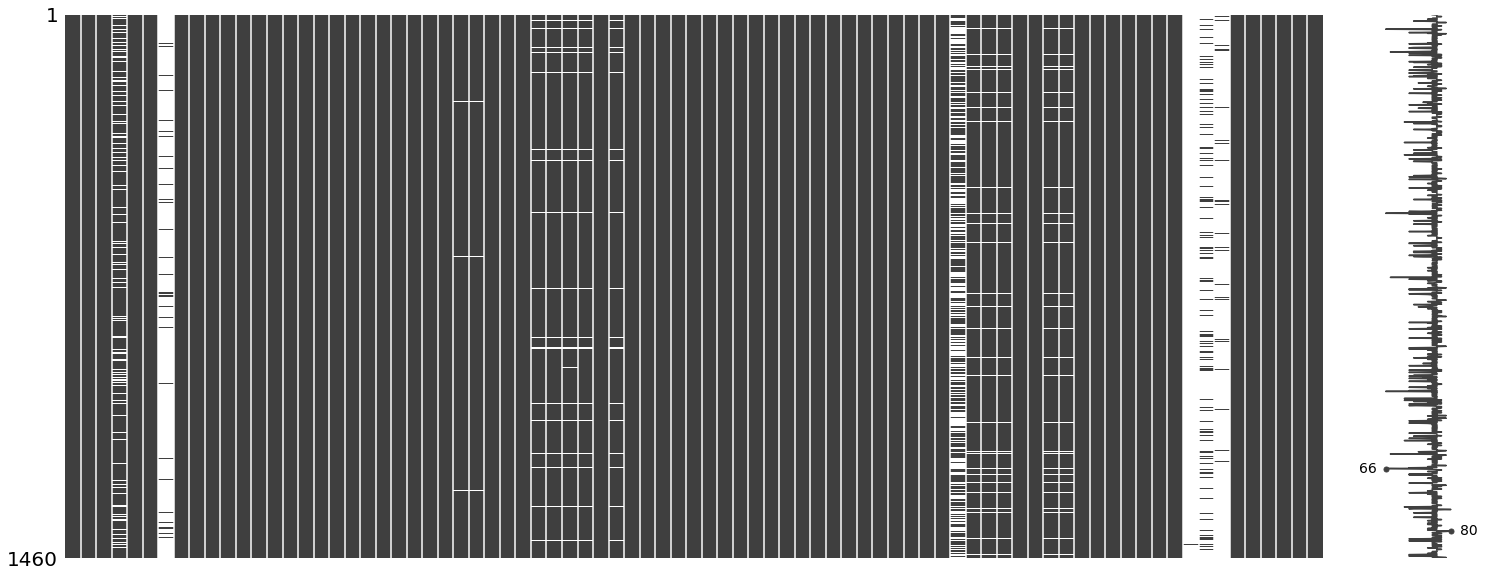

In [10]:
# Generate a visual of missing values in houses_working
report_null_entries(houses_working)

In [14]:
# Run the null report function for categorical columns
cat_cols = null_rpt_cat_cols(houses_working)

# Display only the columns with null values
cat_cols[cat_cols["total_missing"]>0].sort_values(by="total_missing",ascending=False)

,cols,total_missing,percent_missing,uniques
36,poolqc,1453,0.995205,3
32,miscfeature,1406,0.963014,4
0,alley,1369,0.937671,2
15,fence,1179,0.807534,4
16,fireplacequ,690,0.472603,5
19,garagecond,81,0.055479,5
20,garagefinish,81,0.055479,3
21,garagequal,81,0.055479,5
22,garagetype,81,0.055479,6
3,bsmtexposure,38,0.026027,4


It is the case that not all null values are the same.  In this dataset "NA" in categorical variables menas no "x" category: 
- _poolqu_: Pool Quality
    - _poolqc_ can be addresses with targeted filling as the number of nulls == the number of _poolarea_ == 0
    - the "NA" value will be changed to "no_pool"
- _miscfeature_: Miscellaneous feature not covered in other categories
    - _miscfeature_ can be addressed with targeted filling as the number of nulls == the number of _miscval_ == 0
    - the "NA" value will be changed to "no_misc"
- _alley_ will be dropped for insufficient data
- _fence_ will be dropped for insufficient data 
- _fireplacequ_: Fireplace Quality
    - _fireplacequ_ can be addressed with targeted filling as the number of nulls == the number of _fireplaces_ == 0
    - the "NA" value will be changed to "no_fireplace"
- The garage categories: _garagecond, garagefinish, garagequal, garagetype_, Garage Condition, Garage Finish, Garage Quality, and Garage Type respectivly, can be consolidated and checked against _garagearea_.
    - _garagecond, garagefinish, garagequal, garagetype_ can be addressed with targeted filling as the number of nulls == the number of _garagearea_ == 0
    - The "NA" value for this category group will be changed to "no_garage"
- Like the garage categories, the basement categories: _bsmtexposure, bsmtfintype2, bsmtcond, bsmtfintype1, & bsmtqual_, Basement Exposure, Basement Finish Type 2, Basement Condition, Basement Finsh Type 1, and Basement Quality respectively can be consolidated and checked against _totalbsmtsf_.
    - _bsmtexposure, bsmtfintype2, bsmtcond, bsmtfintype1, & bsmtqual_ can be addressed with targeted filling as the number of nulls == the number of _totalbsmtsf_ == 0
    - The "NA" values for this category group will be changed to "no_basement"
- _masvnrtype_: Masonry Veneer Type
    - _masvnrtype_ can be addressed with targeted filling as a "NA" value means no masonry, change to "no_masonry"
- _electrical_: Electrical System
    - _electrical_ can be addressed with targeted filling, the "NA" value will be replaced with "sbrkr"
    - A check against the Year Built (_yearbuilt_) variable reveals that the home was constructed in 2006 and modern building codes require circuit breakers.  The null value probably arises from an data entry error.

I'll quantify these insights below.  The quantitative basis illustrate the relationship between the categorical variables and the continuous variable that they are checked against.

In [112]:
# poolqc
null_poolqc = houses_working[houses_working["poolqc"].isnull()]
validator_poolqc = houses_working[(houses_working["poolqc"].isnull()) & (houses_working["poolarea"]==0)]

# miscfeature
null_miscfeature = houses_working[houses_working["miscfeature"].isnull()]
validator_miscfeature = houses_working[(houses_working["miscfeature"].isnull()) & (houses_working["miscval"]==0)]

# fireplacequ
null_fireplacequ = houses_working[houses_working["fireplacequ"].isnull()]
validator_fireplacequ = houses_working[(houses_working["fireplacequ"].isnull()) & (houses_working["fireplaces"]==0)]

# garage categories
null_garage_cats = houses_working[(houses_working["garagecond"].isnull()) & 
    (houses_working["garagefinish"].isnull()) & 
    (houses_working["garagequal"].isnull()) & 
    (houses_working["garagetype"].isnull())]
validator_null_garage_cats = houses_working[(houses_working["garagecond"].isnull()) & 
    (houses_working["garagefinish"].isnull()) & 
    (houses_working["garagequal"].isnull()) & 
    (houses_working["garagetype"].isnull()) & 
    (houses_working["garagearea"]==0)]

# basement categories
null_basement_cats = houses_working[(houses_working["bsmtexposure"].isnull()) & 
    (houses_working["bsmtcond"].isnull()) & 
    (houses_working["bsmtfintype1"].isnull()) & 
    (houses_working["bsmtqual"].isnull())]
validator_null_basement_cats = houses_working[(houses_working["bsmtexposure"].isnull()) & 
    (houses_working["bsmtcond"].isnull()) & 
    (houses_working["bsmtfintype1"].isnull()) & 
    (houses_working["bsmtqual"].isnull()) &
    (houses_working["totalbsmtsf"]==0)]

validators = [["poolqc",len(null_poolqc), len(validator_poolqc)], 
    ["miscfeature",len(null_miscfeature), len(validator_miscfeature)],
    ["fireplacequ",len(null_fireplacequ), len(validator_fireplacequ)], 
    ["garage_categories",len(null_garage_cats), len(validator_null_garage_cats)],
    ["basement_categories",len(null_basement_cats), len(validator_null_basement_cats)]]

display(pd.DataFrame(validators, columns=["variable","variable_nulls","quanitative_check"]))

yr_built = houses_working["yearbuilt"].loc[houses_working["electrical"].isnull()].item()
print(f"\nValidating modern construction for missing electrical variable observation; year built: {yr_built}")

,variable,variable_nulls,quanitative_check
0,poolqc,1453,1453
1,miscfeature,1406,1406
2,fireplacequ,690,690
3,garage_categories,81,81
4,basement_categories,37,37



Validating modern construction for missing electrical variable observation; year built: 2006


I'll deal with the null replacement shortly but first, I'll examine the nulls for the continuous variables.  As you can see below there are three continuous columns with null values that must be dealt with.

In [15]:
# Run the null report function for condinuous columns
contin_cols = null_rpt_contin_cols(houses_working)

# Display only the columns with null values
contin_cols[contin_cols["total_missing"]>0].sort_values(by="total_missing",ascending=False)

,cols,total_missing,percent_missing,uniques
18,lotfrontage,259,0.177397,110
12,garageyrblt,81,0.055479,97
20,masvnrarea,8,0.005479,327


- _lotfrontage_: Linear feet of street connected to property
    - With regard to null values in the lotfrontage variable I was not able to establish a method for calculating the frontage from other variable.  I'll use interpolation to fill the median value for the variable using the _mszoning_ and _neighborhood_ variables to narrow the value options.
- _garageyrblt_: The year the garage was built
    - This variable has a relationship with the categorical variables, _garagetype_ and _garagefinish_.  When these variable have null values, there is no garage.  To keep from dropping the rows entirely, I'll fill the _garageyrblt_ variable with the value in the _yearbuilt_ variable for the observation.
- _masvnrarea_: Masonry veneer type
    - _masvnrarea_ can filled with a zero as the variables _masvnrtype_, _exterior1st_, _exterior2nd_ verify that a zero value is approprate.

In [291]:
# Nulls in "lotfrontage"
lotfrontage_nulls = contin_cols.loc[18,"total_missing"]

# Nulls in "garageyrblt"
garageyrblt_nulls = contin_cols.loc[12,"total_missing"]

# Nulls in "masvnrarea"
masvnrarea_nulls = contin_cols.loc[20,"total_missing"]

# Verify that the number of the nulls in "garageyrblt" == null values in "garagetype", "garagefinish"
validator_garageyrblt_nulls = houses_working[["yearbuilt","garageyrblt",
    "garagetype","garagefinish"]].loc[houses_working["garageyrblt"].isnull()]

# Verify that then number of nulls in "masvnrarea" == null values in "masvnrtype", "exterior1st","exterior2nd"
houses_working[["masvnrarea","masvnrtype",
    "exterior1st","exterior2nd"]].loc[(houses_working["masvnrarea"].isnull())]

houses_working[(houses_working["miscfeature"].isnull()) & (houses_working["miscval"]==0)]

validators2 = [["lotfrontage", lotfrontage_nulls, 0],
    ["garageyrblt",garageyrblt_nulls,len(validator_garageyrblt_nulls)], 
    ["masvnrarea",masvnrarea_nulls,len(validator_masvnrarea_nulls)]]

display(pd.DataFrame(validators2, columns=["variable","variable_nulls","quanitative_check"]))

,variable,variable_nulls,quanitative_check
0,lotfrontage,259,0
1,garageyrblt,81,81
2,masvnrarea,8,8


In [382]:
# Replace null values in continuous columns first 
houses_df = houses_working.copy()

# Replace nulls in "lotfrontage" transformation
houses_df["lotfrontage"] = houses_df.groupby(["mszoning",
    "neighborhood"])["lotfrontage"].transform(lambda x: x.fillna(x.median()))

# Assign value of null observation to anomymous variable for immediate use to make mean operation more readable
_ = houses_df[["lotarea"]].iloc[466].values[0]
# Get the mean of the closest five observations that cover a similar area
_ = houses_df.iloc[(houses_df["lotarea"] - _).abs().argsort()[:5]]["lotfrontage"].mean()
# Fill the remaining null observation with the anonymous variable from above
houses_df["lotfrontage"].fillna(_,inplace=True)

# Fill "garageyrblt" with value from "hearbuilt"
houses_df["garageyrblt"].fillna(houses_df["yearbuilt"],inplace=True)

# Fill "masvnrarea" with zero where "masvnrtype", "exterior1st", "exterior2nd" are null
houses_df.loc[(houses_df["masvnrtype"].isnull()) & (houses_df["masvnrarea"].isnull()), "masvnrarea"] = 0

# Fill null poolqc with "no_pool" where poolarea == 0
houses_df.loc[(houses_df["poolqc"].isnull()) & 
    (houses_df["poolarea"]==0),"poolqc"] = "no_pool"

# Fill null miscfeature with "no_misc" where the calculated value == 0
houses_df.loc[(houses_df["miscfeature"].isnull()) & (houses_df["miscval"]==0), "miscfeature"] = "no_misc"

# Fill null fireplacequ with "no_fireplace" where the number of fireplaces == 0
houses_df.loc[(houses_df["fireplacequ"].isnull()) & (houses_df["fireplaces"]==0), "fireplacequ"] = "no_fireplace"

# Fill the garage categroicals: garagecond, garagefinish, garagequal, garagetype 
# with "no_garage" where garagearea == 0
houses_df.loc[(houses_df["garagearea"]==0), ["garagecond","garagefinish","garagequal","garagetype"]] = "no_garage"

# Fill the basement categroicals: bsmtexposure, bsmtcond, bsmtfintype1, bsmtqual 
# with "no_basement" where totalbsmtsf == 0
houses_df.loc[(houses_df["totalbsmtsf"]==0), ["bsmtexposure","bsmtcond","bsmtfintype1","bsmtqual"]] = "no_basement"

# Deal with remaing observation of null bsmtexposure by filling with "No"
houses_df.fillna("No",inplace=True)

# Fill masvnrtype with "no_masonary" as null values == no masonary
houses_df["masvnrtype"].fillna("no_masonary",inplace=True)

# Fill the missing observation for electrical 
houses_df["electrical"].fillna("sbrkr",inplace=True)

null_lotfrontage = houses_df["lotfrontage"].isnull().sum()
null_garageyrblt = houses_df["garageyrblt"].isnull().sum()
null_masvnrarea = houses_df["masvnrarea"].isnull().sum()
null_poolqc = houses_df["poolqc"].isnull().sum()
null_miscfeature = houses_df["miscfeature"].isnull().sum()
null_fireplacequ = houses_df["fireplacequ"].isnull().sum()
null_garage_categories = houses_df[["garagecond","garagefinish","garagequal","garagetype"]].isnull().sum()
null_basement_categories = houses_df[["bsmtexposure", "bsmtcond", "bsmtfintype1", "bsmtqual"]].isnull().sum()
null_masvnrtype = houses_df["masvnrtype"].isnull().sum()
null_electrical = houses_df["electrical"].isnull().sum()

print(f"Null lotfrontage: {null_lotfrontage}")
print(f"Null garageyrblt: {null_garageyrblt}")
print(f"Null masvnrarea: {null_masvnrarea}")
print(f"Null poolqc: {null_poolqc}")
print(f"Null miscfeature: {null_miscfeature}")
print(f"Null fireplacequ: {null_fireplacequ}")
print(f"Null garage categories: {null_garage_categories}")
print(f"Null basement categories: {null_basement_categories}")
print(f"Null masvnrtype: {null_masvnrtype}")
print(f"Null electrical: {null_electrical}")

Null lotfrontage: 0
Null garageyrblt: 0
Null masvnrarea: 0
Null poolqc: 0
Null miscfeature: 0
Null fireplacequ: 0
Null garage categories: garagecond      0
garagefinish    0
garagequal      0
garagetype      0
dtype: int64
Null basement categories: bsmtexposure    0
bsmtcond        0
bsmtfintype1    0
bsmtqual        0
dtype: int64
Null masvnrtype: 0
Null electrical: 0


Drop the columns: alley and fence as I was unable to sufficiently deal with quantity of null values in each variable.

In [383]:
# Remove the alley and fence variables from consideration
houses_df.drop(columns=["alley","fence"], inplace=True)

### Exploratory Data Analysis EDA

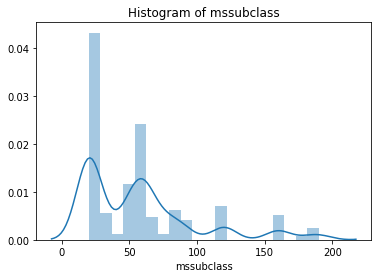

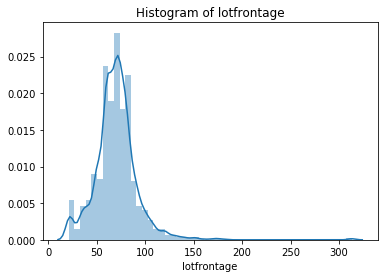

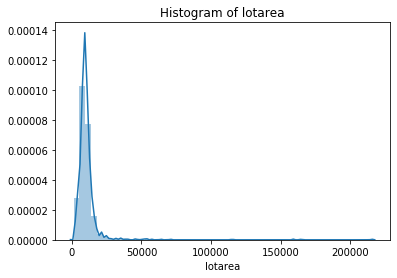

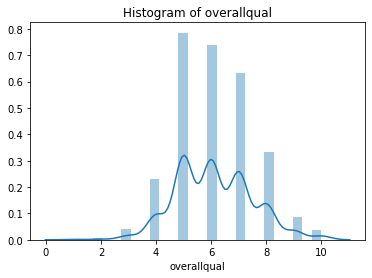

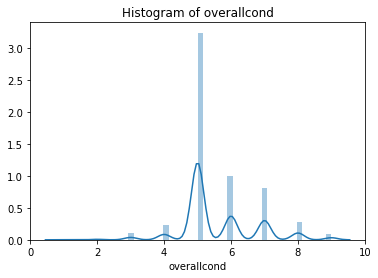

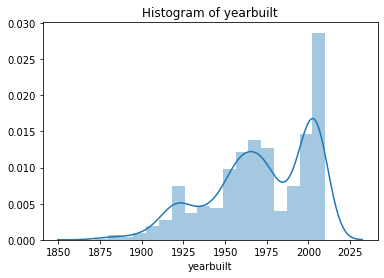

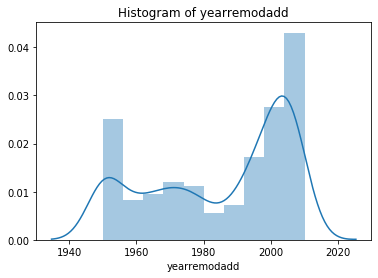

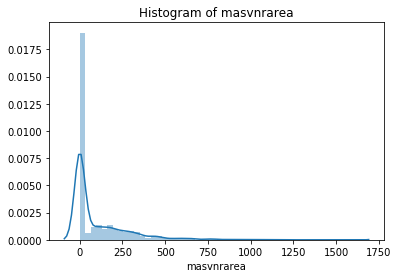

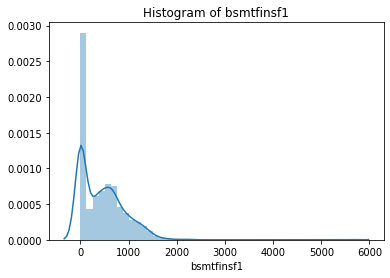

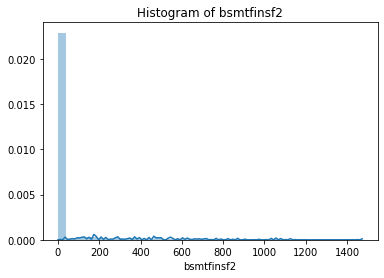

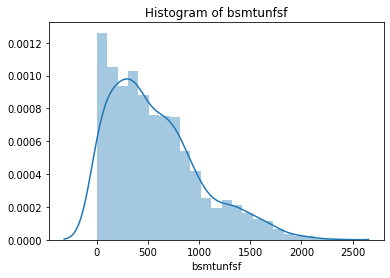

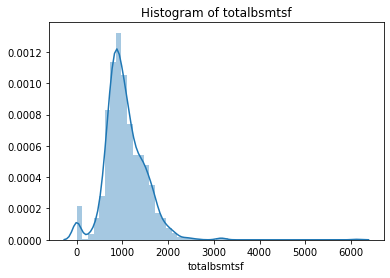

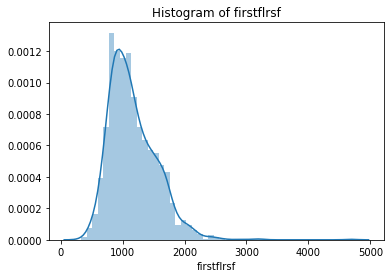

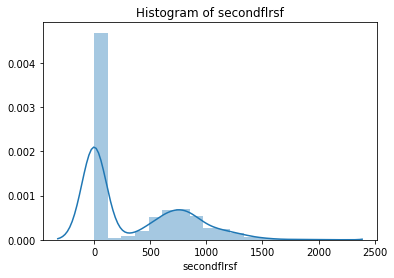

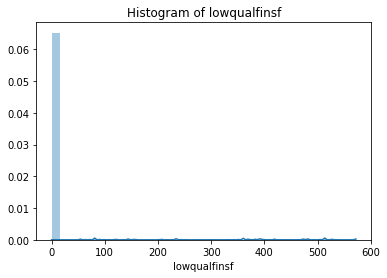

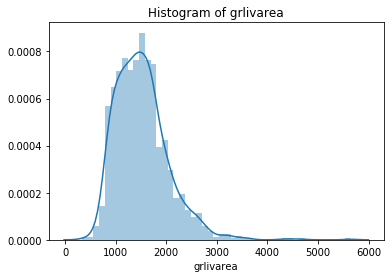

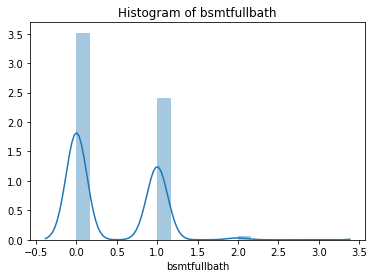

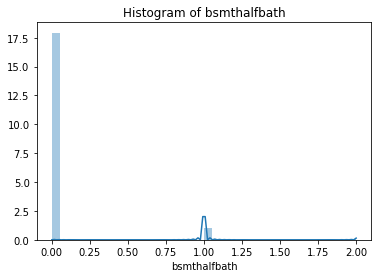

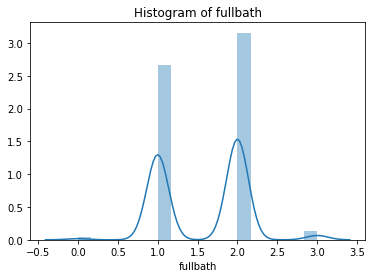

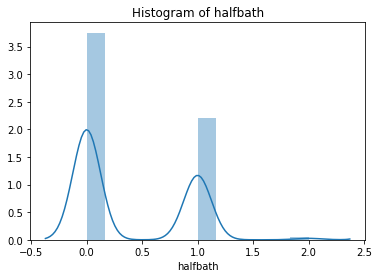

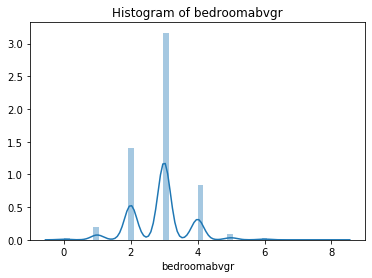

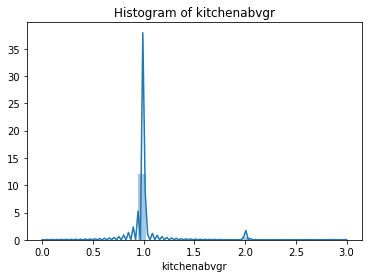

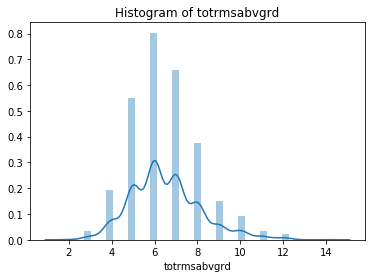

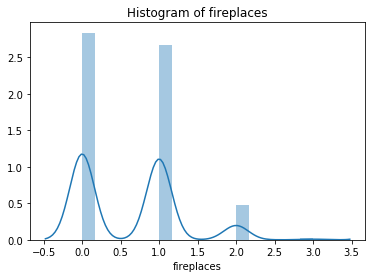

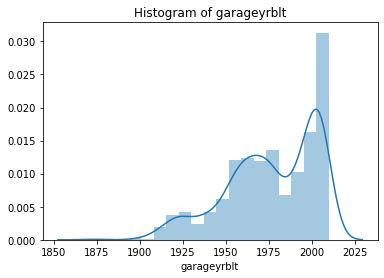

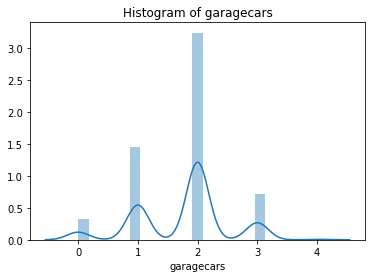

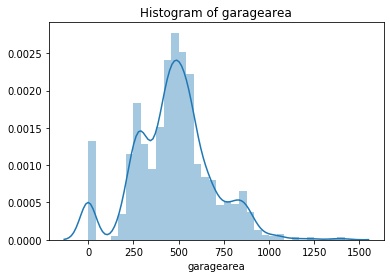

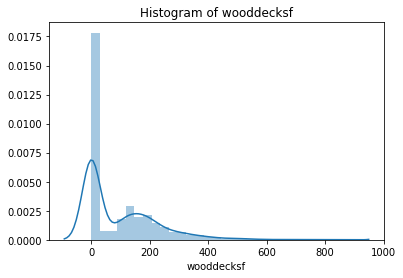

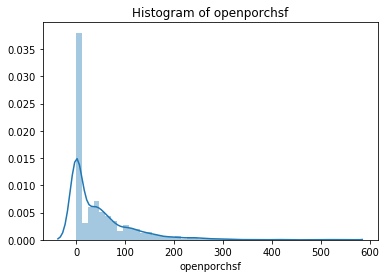

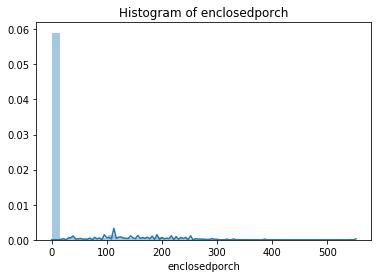

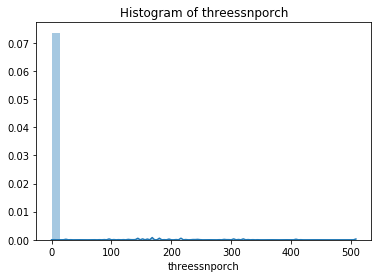

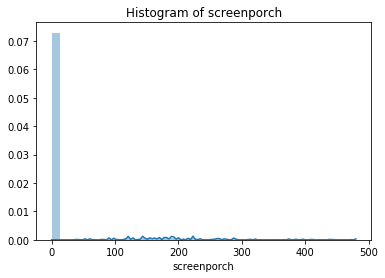

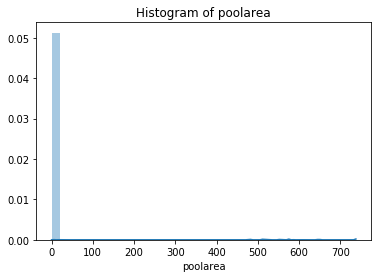

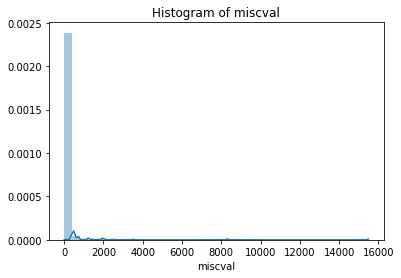

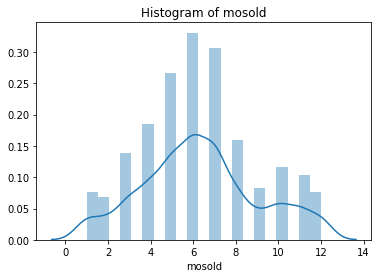

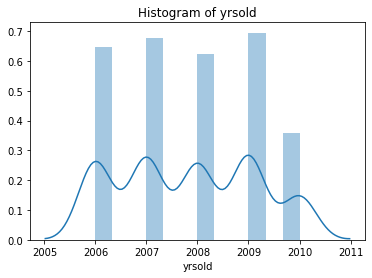

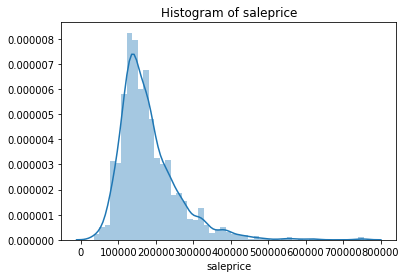

In [410]:
# Visualize the continuous columns to get a sense of their distributions
cols = houses_df.select_dtypes(exclude=["object","datetime"]).columns[1:]
plt_cols = 3
rows = math.ceil(len(cols)/plt_cols)

# plt.figure(figsize=(37,18))
for i,col in enumerate(cols):
    # col = houses_df.iloc[:, [i]].columns[0]
    # plt.subplot(rows,plt_cols,(i+1))
    sns.distplot(houses_df[f"{col}"])
    plt.title(f"Histogram of {col}")

    plt.show();

In [395]:
math.ceil(len(cols)/3)

13